<img src="../../docs/images/dlsia.png" width=600 />

# Segmention demo in 2D using Mixed-scale Dense Networks and Tunable U-Nets

**Authors:** Eric Roberts and Petrus Zwart

**E-mail:** PHZwart@lbl.gov, EJRoberts@lbl.gov

This notebook highlights some basic functionality with the dlsia package and acts as an introduction to to dlsia capabilities.

Using the pyMSDtorch framework, we initialize two convolutional neural networks, a mixed-scale dense network (MSDNet) and a tunable U-Net (TUNet), and train both networks to perform multi-class segmentation on noisy data.

## Installation and imports

We offer several methods for installation.

### pip: Python package installer

The latest stable relsease may be installed with:

```
$ pip install dlsia .
```

### From source

dlsia may be directly downloaded and installed into your machine by cloning the public repository into an empty directory using:

```
$ git clone https://github.com/phzwart/dlsia.git .
```

Once cloned, move to the newly minted pymsdtorch directory and install using:

```
$ cd dlsia
$ pip install .
```

### Imports

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import TensorDataset, DataLoader

from dlsia.core import helpers, train_scripts
from dlsia.core.networks import msdnet, tunet, tunet3plus
from dlsia.test_data.two_d import random_shapes
from dlsia.viz_tools import plots

import matplotlib.pyplot as plt
from torchmetrics import F1Score

from IPython.display import Image

## Create Data

Using our dlsia in-house data generator, we produce a number of noisy "shapes" images consisting of single triangles, rectangles, circles, and donuts/annuli, each assigned a different class. In addition to augmenting with random orientations and sizes, each raw, ground truth image will be bundled with its corresponding noisy and binary mask.

### Parameters to toggle:
- n_imgs : number of ground truth/noisy/label image bundles to generate
- noise_level :  per-pixel noise drawn from a continuous uniform distribution (cut-off above at 1)
- N_xy : size of individual images

In [2]:
n_imgs = 100
noise_level = .75
n_xy = 32

img_dict = random_shapes.build_random_shape_set_numpy(n_imgs=n_imgs,
                                                      noise_level=noise_level,
                                                      n_xy=n_xy)

In [3]:
ground_truth = img_dict['GroundTruth']
noisy        =  img_dict['Noisy']
mask         = img_dict['ClassImage']
shape_id        = img_dict['Label']

ground_truth = np.expand_dims(ground_truth, axis=1)
noisy = np.expand_dims(noisy, axis=1)
mask = np.expand_dims(mask, axis=1)
shape_id = np.expand_dims(shape_id, axis=1)

print('Verify date type and dimensionality: ', type(ground_truth), ground_truth.shape)

Verify date type and dimensionality:  <class 'numpy.ndarray'> (100, 1, 32, 32)


### View data

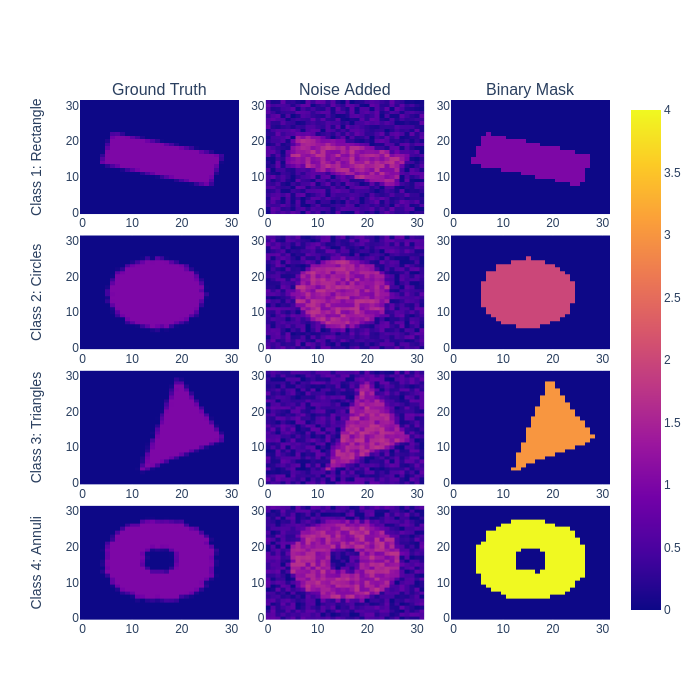

<Figure size 64x48 with 0 Axes>

In [4]:
# Normally we would use interactive plot here via plots.plot_shapes_data_numpy(img_dict).show(),
# but they don't survive when displayed in github, so we make it a static plot instead.

tmp = plots.plot_shapes_data_numpy(img_dict)
tmp = tmp.to_image(format="png", scale=1.0)
plt.figure(dpi=10)
Image(tmp)

### Training/Validation/Testing Splits

Of the data we generated above, we partition it into non-overlapping subsets to be used for training, validation, and testing. (We somewhat arbitrarily choose a 80-10-10 percentage split). 

As a refresher, the three subsets of data are used as follows:

- training set : this data is used to fit the model,
- validation set : passed through the network to give an unbiased evaluation during training (model does not learn from this data),
- testing set : gives an unbiased evaluation of the final model once training is complete.

In [5]:
# Split training set
n_train        = int(0.8 * n_imgs)
training_imgs  = noisy[0:n_train,...]
training_masks = mask[0:n_train,...]

# Split validation set
n_validation     = int(0.1 * n_imgs)
validation_imgs  = noisy[(n_train) : (n_train+n_validation),...]
validation_masks = mask[(n_train) : (n_train+n_validation),...]

# Split testing set
n_testing     = int(0.1 * n_imgs)
testing_imgs  = noisy[-n_testing:, ...]
testing_masks = mask[-n_testing:, ...]

# Cast data as tensors and get in PyTorch Dataset format
train_data = TensorDataset(torch.Tensor(training_imgs), torch.Tensor(training_masks))
val_data   = TensorDataset(torch.Tensor(validation_imgs), torch.Tensor(validation_masks))
test_data  = TensorDataset(torch.Tensor(testing_imgs), torch.Tensor(testing_masks))

### Dataloader class

We make liberal use of the PyTorch Dataloader class for easy handling and iterative loading of data into the networks and models. 

<b>** Note ** </b> The most important parameters to specify here are the <b>batch_sizes</b>, as these dictate how many images are loaded and passed through the network at a single time. By extension, controlling the batch size allows you to control the GPU/CPU usage. As a rule of thumb, the bigger the batch size, the better; this not only speeds up training, certain network normalization layers (e.g. BatchNorm2dbatch) become more stable with larger batches.

<b>Dataloader Reference:</b> https://pytorch.org/docs/stable/data.html

In [6]:
# Specify batch sizes
batch_size_train = 50 
batch_size_val   = 50 
batch_size_test  = 50

# Set Dataloader parameters (Note: we randomly shuffle the training set upon each pass)
train_loader_params = {'batch_size': batch_size_train,
                       'shuffle': True}
val_loader_params   = {'batch_size': batch_size_val,
                       'shuffle': False}
test_loader_params  = {'batch_size': batch_size_test,
                       'shuffle': False}

# Build Dataloaders
train_loader = DataLoader(train_data, **train_loader_params)
val_loader   = DataLoader(val_data, **val_loader_params)
test_loader  = DataLoader(test_data, **test_loader_params)

## Create Networks

Here we instantiate three different convolutional neural networks: a mixed-scale dense network (MSDNet), a tunable U-Net (TUNet), and TUNet3+, a variant that connects all length scales to all others.

Each network takes in a single grayscale channel and produces five output channels, one for each of the four shapes and one for background. Additionally, as is standard practice, each network applies a batch normalization and rectified linear unit activation (BatchNorm2d ==> ReLU) bundle after each convolution to expedite training.

<b>** Note ** </b> From the authors' experiences, batch normalization has stabalized training in problems EXCECPT when data is strongly bimodal or with many (>90%) zeros (e.g. inpainting or masked data). This is likely due (though admittedly, hand-wavey) to the mean-shifting of the data 'over-smoothing' and losing the contrast between the two peaks of interest.

### Vanilla MSDNet 

The first is a mixed-scale dense convolutional neural network (MSDNet) which densely connects ALL input, convolutional, and output layers together and explores different length scales using dilated convolutions.

Some parameters to toggle:

- num_layers : The number of convolutional layers that are densely-connected
- max_dilation : the maximum dilation to cycle through (default is 10)

For more information, see pyMSDtorch/core/networks/MSDNet.py 

In [7]:
in_channels = 1
out_channels = 5
num_layers = 50            
max_dilation = 8     
activation = nn.ReLU()
normalization = nn.BatchNorm2d  # Change to 3d for volumous data

In [8]:
msdnet_model = msdnet.MixedScaleDenseNetwork(in_channels = in_channels,
                                             out_channels = out_channels, 
                                             num_layers=num_layers, 
                                             max_dilation = max_dilation,
                                             activation = activation,
                                             normalization = normalization,
                                             convolution=nn.Conv2d  # Change to 3d for volumous data
                                            )

print('Number of parameters: ', helpers.count_parameters(msdnet_model))

## To view module listing, simply print
#print(msdnet_model)

## For a more detailed view, we advocate using torchsummary

#from torchsummary import summary
#summary(msdnet_model.to(device), (in_channels, n_xy, n_xy))

Number of parameters:  14435


### MSDNet with custom dilations

As an alternative to MSDNets with repeated and cycling dilation sizes, we allow the user to input custom dilations in the form of a 1D numpy array. 

For example, create an 18-layer network that cycles through increasing powers of two as dilations by passing the parameters

```python
num_layers = 25
custom_msdnet = np.array([1,2,4,8]).
```

In [9]:
custom_msdnet = np.array([1,2,4,8])

msdnet_custom = msdnet.MixedScaleDenseNetwork(in_channels=in_channels,
                                              out_channels=out_channels,
                                              num_layers=num_layers,
                                              custom_msdnet=custom_msdnet,
                                              activation=activation,
                                              normalization=normalization,
                                              convolution=nn.Conv2d  # Change to 3d for volumous data
                                             )

print('Number of parameters: ', helpers.count_parameters(msdnet_custom))

Number of parameters:  14435


### Tunable U-Net (TUNet)

Next, we create a custom U-Net with the following architecture-governing parameters

- depth: the number of network layers
- base_channels: number of initial channels
- growth_rate: multiplicative growth factor of number of channels per layer of depth
- hidden_rate: multiplicative growth factor of channels within each layer

Please note the two rate parameters can be non-integer numbers

As with MSDNets, the user has many more options to customize their TUNets, including the normalization and activation functions after each convolution. See dlsia/core/networks/TUNet.py for more.

**Recommended parameters are depth = 4, 5, or 6; base_channels = 32 or 64; growth_rate between 1.5 and 2.5; and hidden_rate = 1**

In [10]:
image_shape = (n_xy, n_xy)
depth = 4
base_channels = 16
growth_rate = 2
hidden_rate = 1

In [11]:
tunet_model = tunet.TUNet(image_shape=image_shape,
                          in_channels=in_channels,
                          out_channels=out_channels,
                          depth=depth,
                          base_channels=base_channels,
                          growth_rate=growth_rate,
                          hidden_rate=hidden_rate,
                          activation=activation,
                          normalization=normalization,
                         )

print('Number of parameters: ', helpers.count_parameters(tunet_model))

Number of parameters:  483221


### Tunable U-Net 3+ (TUNet3+)

dlsia allows the user to create a newer UNet variant called UNet3+. Whereas the original UNets shared information from encoder-to-decoder with single skip connections per layer (via concatenations across each layer's matching dimensions), the UNet3+ architecture densely connects information from all layers to all other layers with cleverly vbuilt skip connections (upsample/downsampling to match spatial dimensions, convolutions to control channel growth, then concatenations).

The only additional parameter to declare:

- carryover_channels : indicates the number of channels in each skip connection. Default of 0 sets this equal to base_channels

In [12]:
carryover_channels = base_channels

In [13]:
tunet3plus_model = tunet3plus.TUNet3Plus(image_shape=image_shape,
                                         in_channels=in_channels,
                                         out_channels=out_channels,
                                         depth=depth,
                                         base_channels=base_channels,
                                         carryover_channels=carryover_channels,
                                         growth_rate=growth_rate,
                                         hidden_rate=hidden_rate,
                                         activation=activation,
                                         normalization=normalization,
                                        )

print('Number of parameters: ', helpers.count_parameters(tunet3plus_model))

Number of parameters:  437989


## Training our networks

Below, we start using PyTorch heavily. We define relevant training parameters, the training loop, then compare the two networks defined above.

All networks in this notebook with batch sizes of 50 use between 1.8 and 2.3 GBs of memory for training, easily attainable with even a moderately small GPU.

### Set training parameters

In [14]:
epochs = 10                         # Set number of epochs
criterion = nn.CrossEntropyLoss()   # For segmenting >2 classes
learning_rate = 5e-3

# Define optimizers, one per network
optimizer_msd        = optim.Adam(msdnet_model.parameters(), lr=learning_rate)
optimizer_tunet      = optim.Adam(tunet_model.parameters(), lr=learning_rate)
optimizer_tunet3plus = optim.Adam(tunet3plus_model.parameters(), lr=learning_rate)

device = helpers.get_device()
print('Device we will compute on: ', device)   # cuda:0 for GPU. Else, CPU

Device we will compute on:  cuda:0


### Train MSDNet

In [15]:
msdnet_model.to(device)   # send network to GPU

msdnet_model, results = train_scripts.train_segmentation(msdnet_model,
                                                         train_loader, 
                                                         val_loader, 
                                                         epochs, 
                                                         criterion, 
                                                         optimizer_msd, 
                                                         device, 
                                                         show=10
                                                        )   # training happens here

msdnet_model = msdnet_model.cpu()   # Move model from GPU to CPU

fig = plots.plot_training_results_segmentation(results)
plt.figure(dpi=20)
fig.show()

# clear out unnecessary variables from device (GPU) memory
torch.cuda.empty_cache()

Epoch 10 of 10 | Learning rate 5.000e-03
   Training Loss: 4.4431e-01 | Validation Loss: 4.7071e-01
   Micro Training F1: 0.8975 | Micro Validation F1: 0.8745
   Macro Training F1: 0.5587 | Macro Validation F1: 0.5411


<Figure size 128x96 with 0 Axes>

### Train TUNet

In [16]:
tunet_model.to(device)   # send network to GPU

tunet_model, results = train_scripts.train_segmentation(tunet_model,
                                                        train_loader, 
                                                        val_loader, 
                                                        epochs, 
                                                        criterion, 
                                                        optimizer_tunet, 
                                                        device, 
                                                        show=10
                                                       )   # training happens here
tunet_model = tunet_model.cpu()

fig = plots.plot_training_results_segmentation(results)
plt.figure(dpi=20)
fig.show()

# clear out unnecessary variables from device (GPU) memory
torch.cuda.empty_cache()

Epoch 10 of 10 | Learning rate 5.000e-03
   Training Loss: 6.7980e-01 | Validation Loss: 6.6154e-01
   Micro Training F1: 0.8729 | Micro Validation F1: 0.8388
   Macro Training F1: 0.3628 | Macro Validation F1: 0.3250


<Figure size 128x96 with 0 Axes>

### Train TUNet3+

In [17]:
torch.cuda.empty_cache()
tunet3plus_model.to(device)   # send network to GPU
tunet3plus_model, results = train_scripts.train_segmentation(tunet3plus_model,
                                                             train_loader, 
                                                             val_loader, 
                                                             epochs, 
                                                             criterion, 
                                                             optimizer_tunet3plus, 
                                                             device, 
                                                             show=10)
tunet3plus_model = tunet3plus_model.cpu()

fig = plots.plot_training_results_segmentation(results)
plt.figure(dpi=20)
fig.show()

# clear out unnecessary variables from device (GPU) memory
torch.cuda.empty_cache()

Epoch 10 of 10 | Learning rate 5.000e-03
   Training Loss: 5.2017e-01 | Validation Loss: 5.1083e-01
   Micro Training F1: 0.8839 | Micro Validation F1: 0.8747
   Macro Training F1: 0.3764 | Macro Validation F1: 0.4203


<Figure size 128x96 with 0 Axes>

## Saving networks

Each dlsia network library contains submodules for saving and loading networks.

In [18]:
## Save model
savepath = 'this_tunet.pt'
tunet_model.save_network_parameters(savepath)

## Load model
copy_of_tunet = tunet.TUNetwork_from_file(savepath)

## Testing our networks

Now we pass our testing set images through all the networks network. We'll print out some network predictions and report the multi-class micro adn macro F1 scores, common metrics for gauging network performance.

Images for batch # 0, number 0


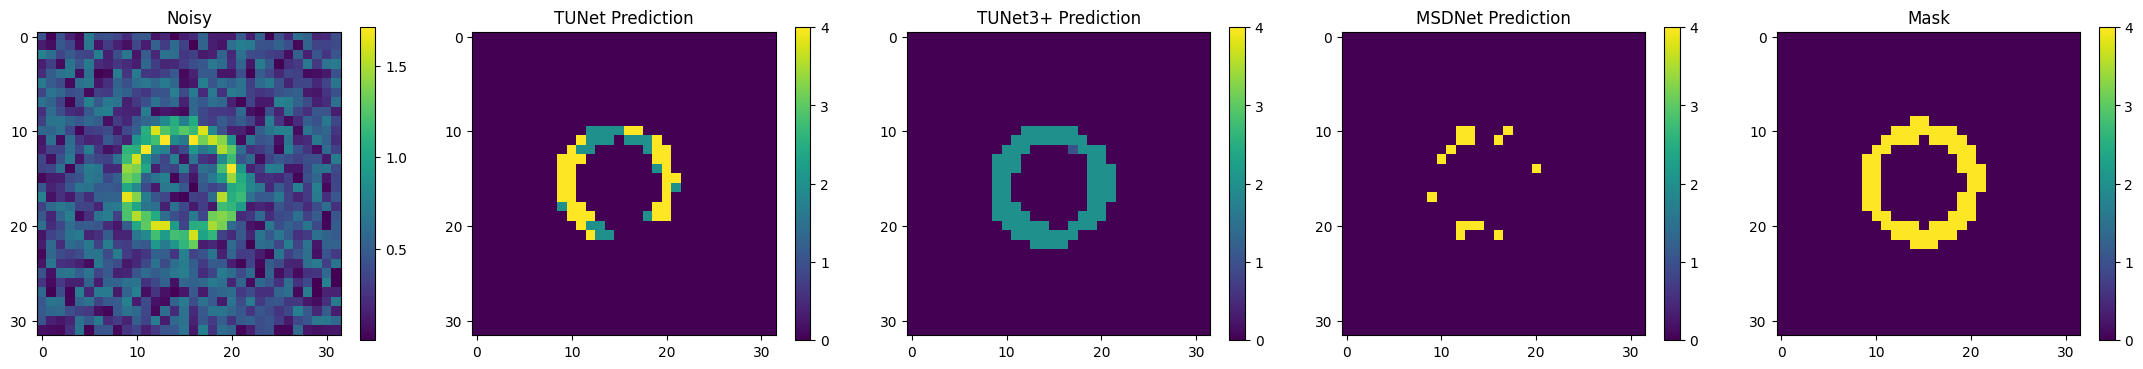

<Figure size 128x96 with 0 Axes>

Images for batch # 0, number 1


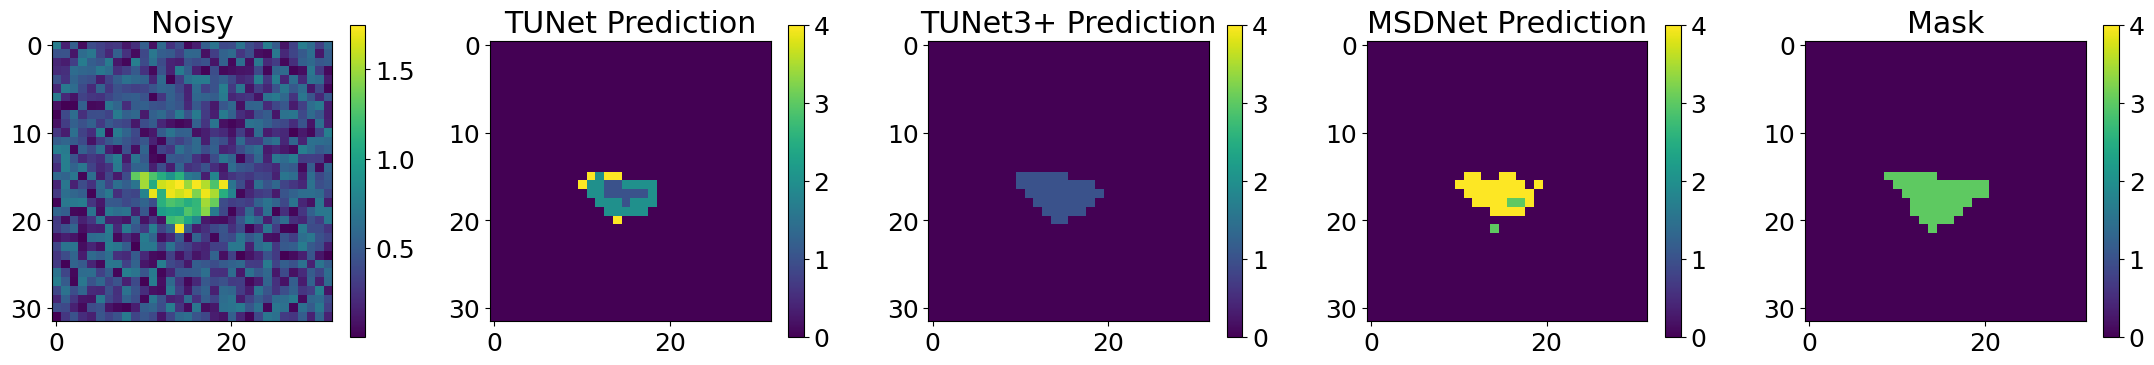

<Figure size 128x96 with 0 Axes>

Images for batch # 0, number 2


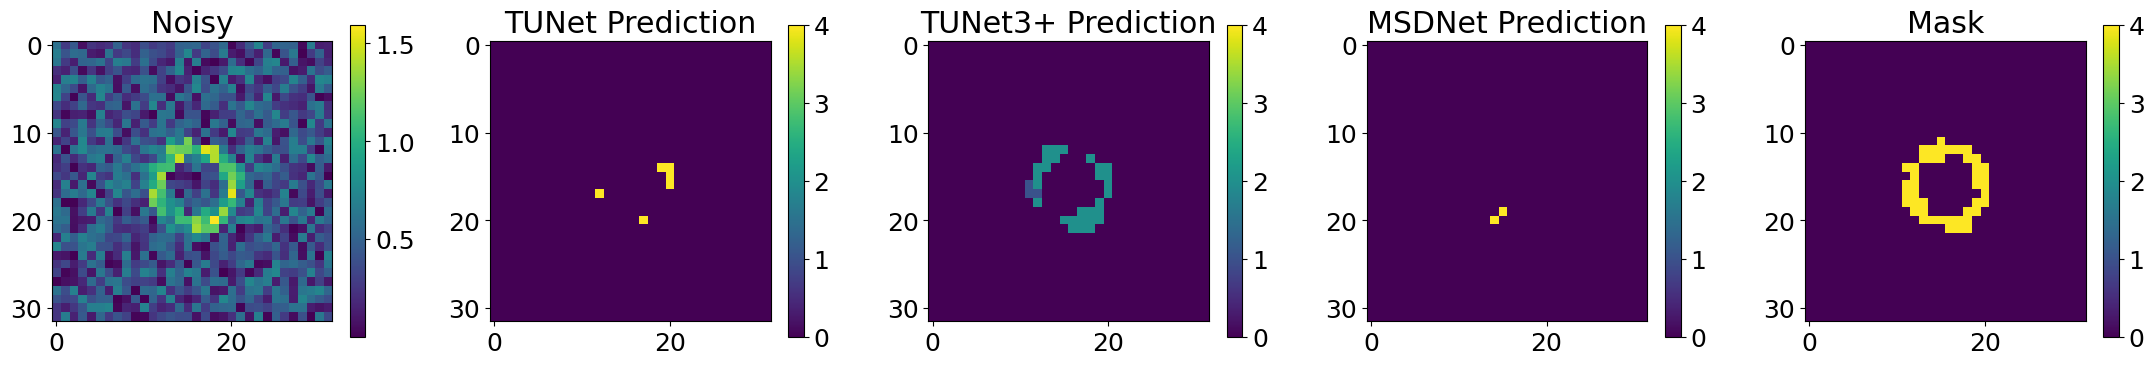

<Figure size 128x96 with 0 Axes>

Images for batch # 0, number 3


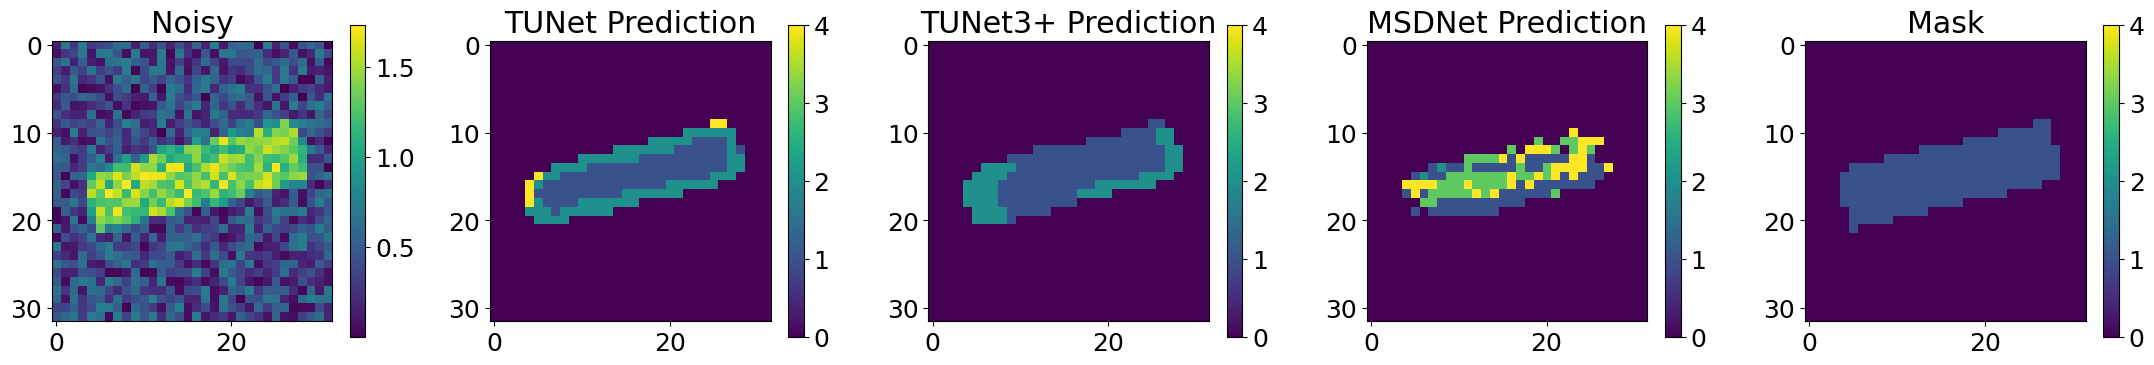

<Figure size 128x96 with 0 Axes>

Images for batch # 0, number 4


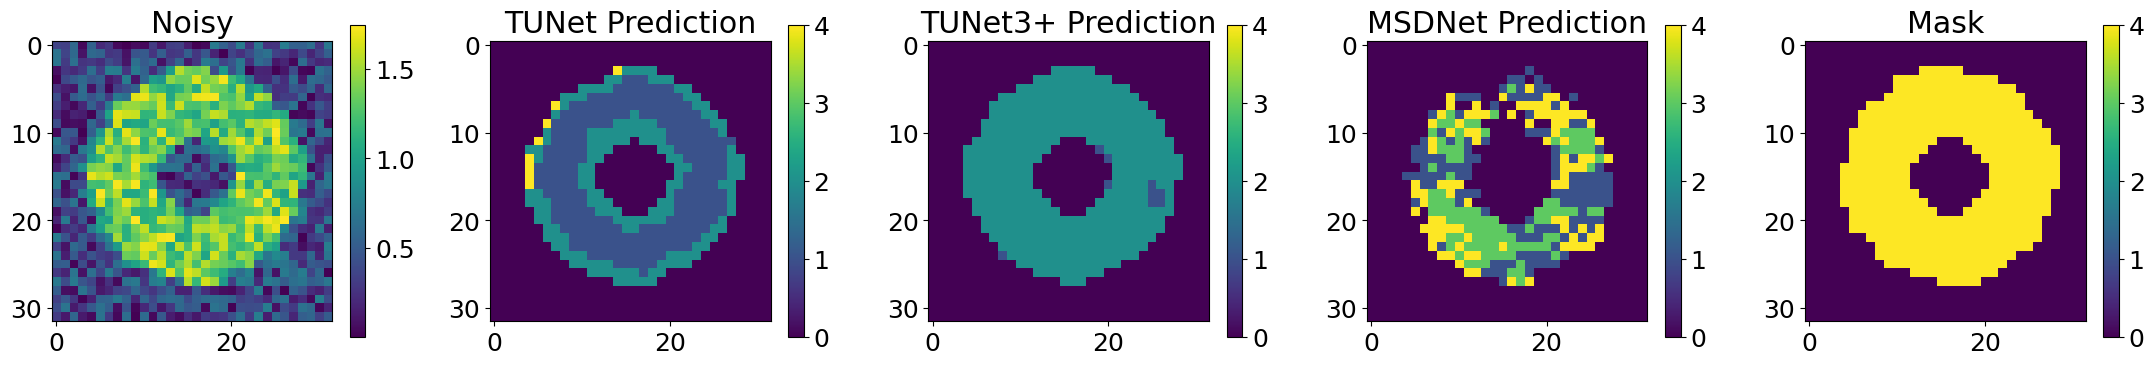

<Figure size 128x96 with 0 Axes>

Images for batch # 0, number 5


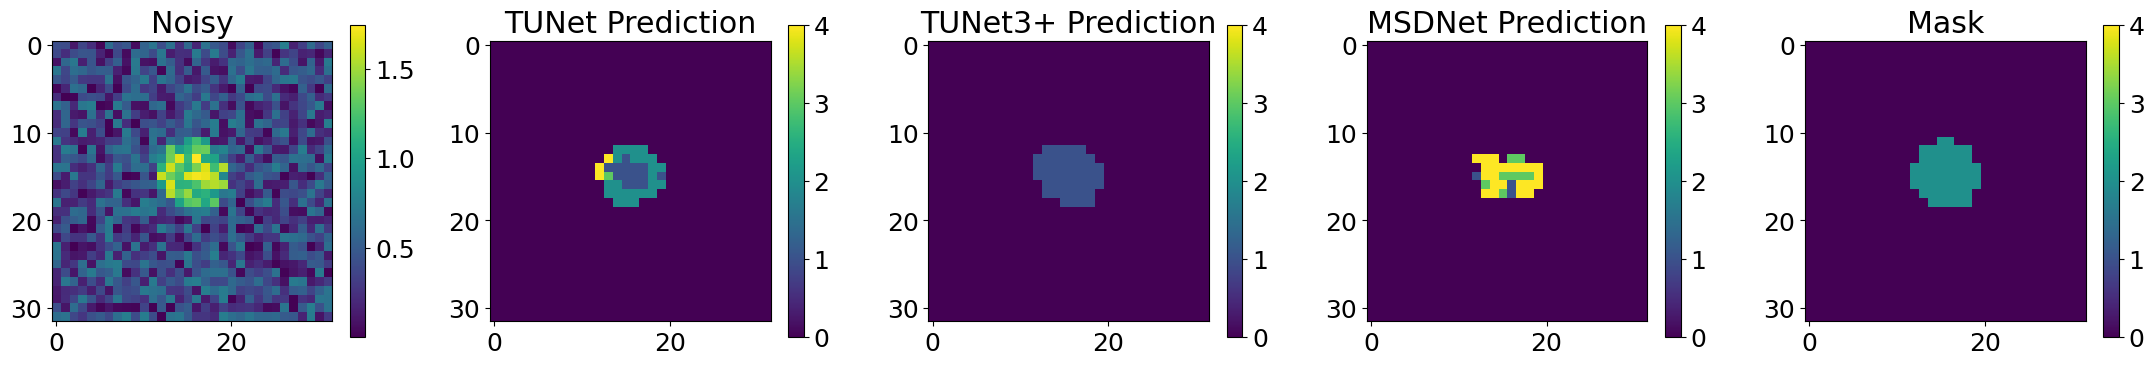

<Figure size 128x96 with 0 Axes>

Images for batch # 0, number 6


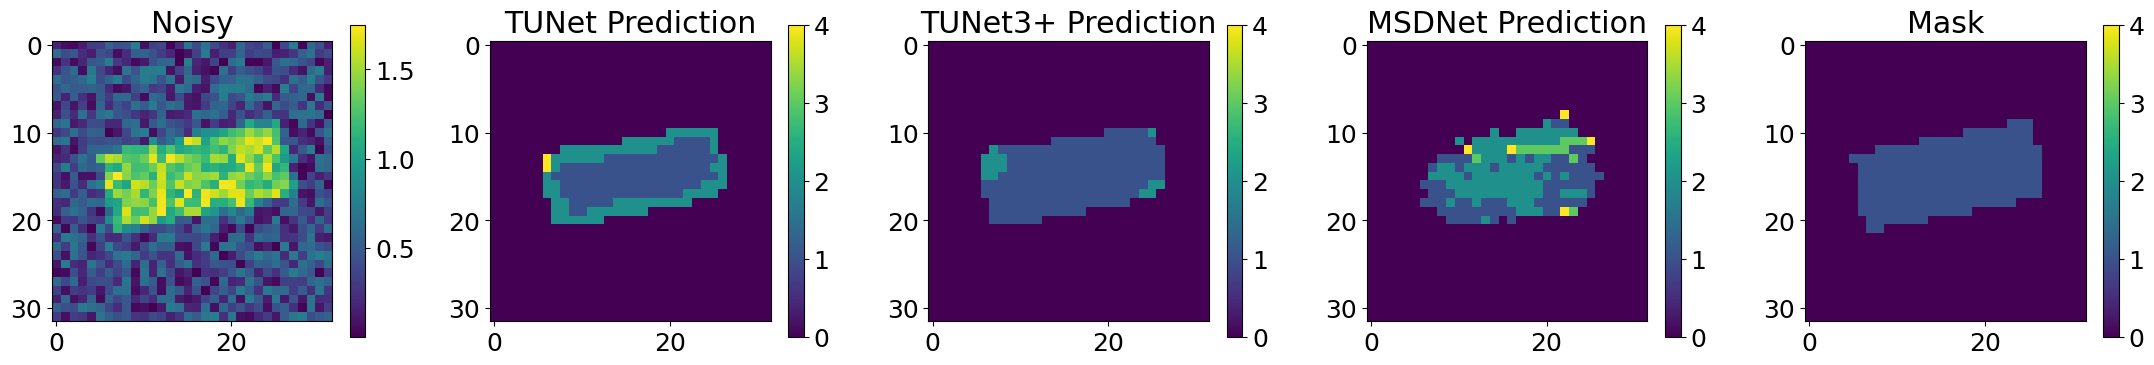

<Figure size 128x96 with 0 Axes>

Images for batch # 0, number 7


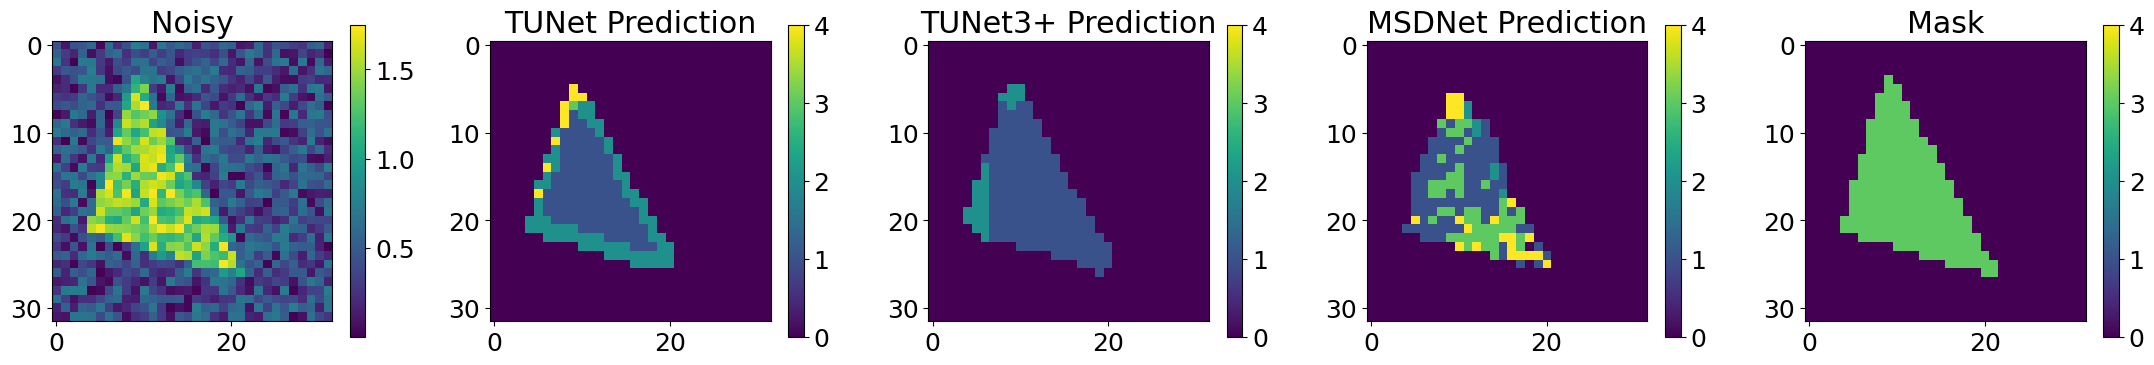

<Figure size 128x96 with 0 Axes>

Images for batch # 0, number 8


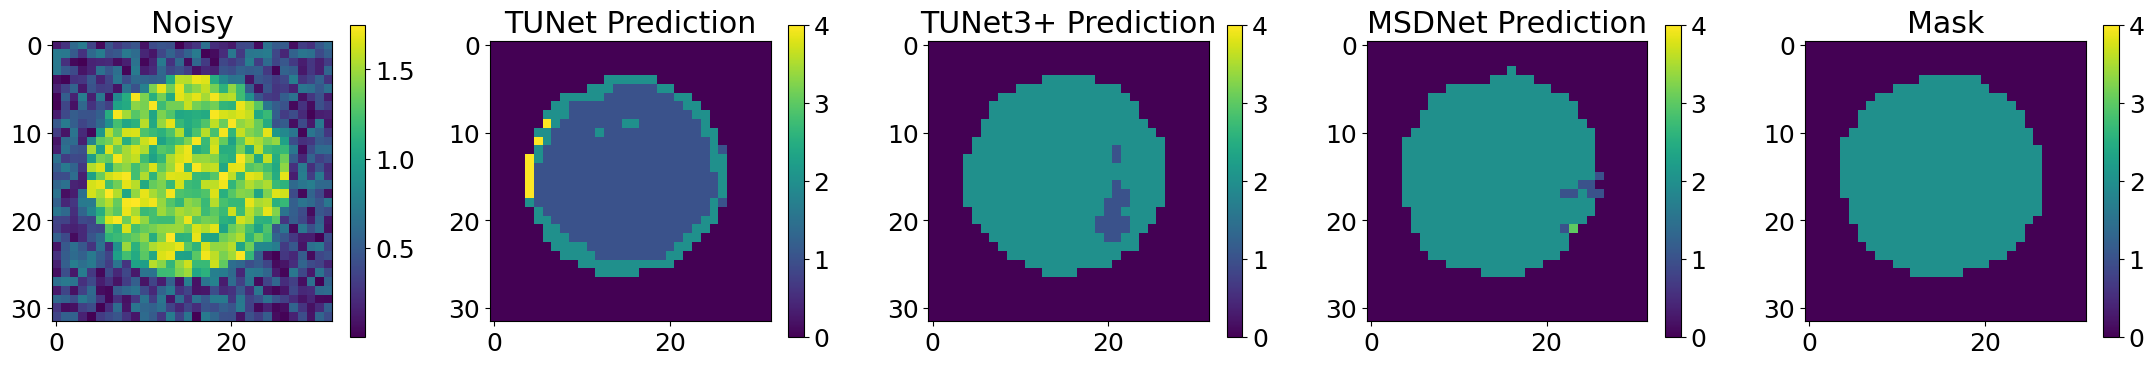

<Figure size 128x96 with 0 Axes>

Images for batch # 0, number 9


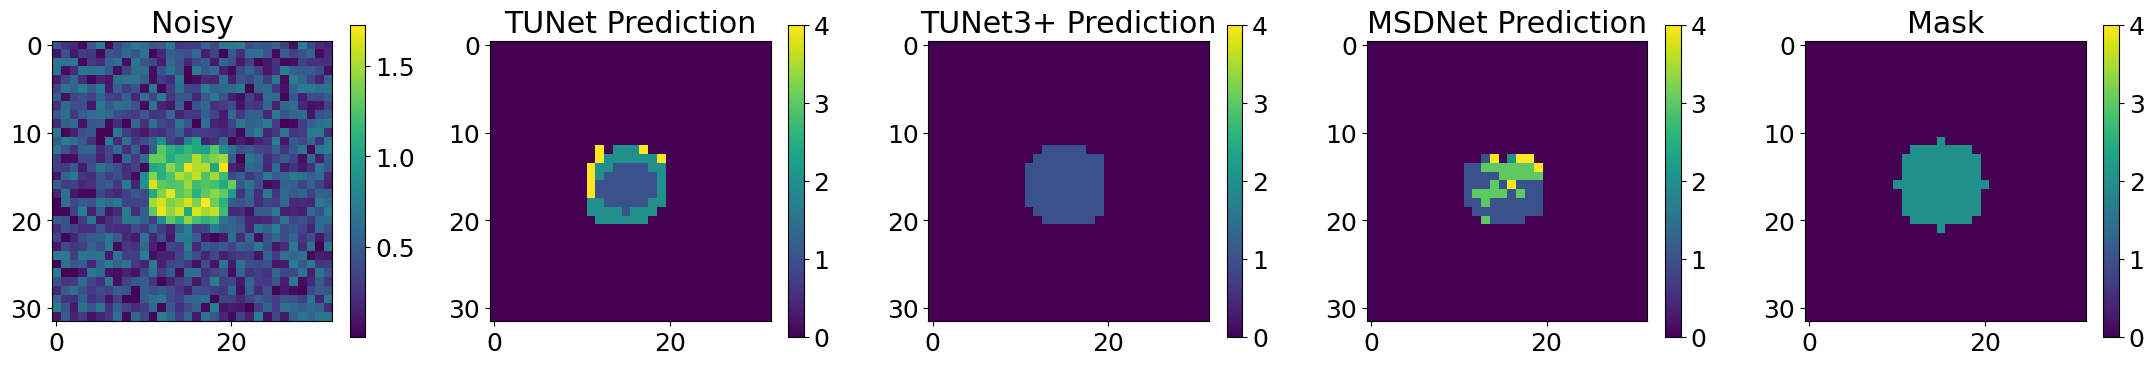

<Figure size 128x96 with 0 Axes>

In [19]:
# Define F1 score parameters and classes

num_classes = out_channels
F1_eval_macro = F1Score(task='multiclass',
                        num_classes=num_classes,
                        average='macro',
                        mdmc_average='global')
F1_eval_micro = F1Score(task='multiclass',
                        num_classes=num_classes,
                        average='micro',
                        mdmc_average='global')

# preallocate 
microF1_tunet      = 0
microF1_tunet3plus = 0
microF1_msdnet     = 0

macroF1_tunet      = 0
macroF1_tunet3plus = 0
macroF1_msdnet     = 0

counter = 0

# Number of testing predictions to display
num_images = 10
num_images = np.min((num_images, batch_size_test))
device = "cpu"
for batch in test_loader:
    with torch.no_grad():
        #net.eval()   # Bad... this ignores the batchnorm parameters
        noisy, target = batch

        # Necessary data recasting
        noisy = noisy.type(torch.FloatTensor)
        target = target.type(torch.IntTensor)
        noisy = noisy.to(device)
        target = target.to(device).squeeze(1)

        # Input passed through networks here
        output_tunet      = tunet_model(noisy)
        output_tunet3plus = tunet3plus_model(noisy)  
        output_msdnet     = msdnet_model(noisy)  
        # Individual output passed through argmax to get predictions
        preds_tunet = torch.argmax(output_tunet.cpu().data, dim=1) 
        preds_tunet3plus = torch.argmax(output_tunet3plus.cpu().data, dim=1) 
        preds_msdnet = torch.argmax(output_msdnet.cpu().data, dim=1) 
        shrink=0.7
        for j in range(num_images):


            print(f'Images for batch # {counter}, number {j}')
            plt.figure(figsize=(22,5))

            # Display noisy input
            plt.subplot(151)
            plt.imshow(noisy.cpu()[j,0,:,:].data) 
            plt.colorbar(shrink=shrink)
            plt.title('Noisy')

            # Display tunet predictions
            plt.subplot(152)            
            plt.imshow(preds_tunet[j,...]) 
            plt.colorbar(shrink=shrink) 
            plt.clim(0,4) 
            plt.title('TUNet Prediction')    

            # Display tunet3+ predictions
            plt.subplot(153)            
            plt.imshow(preds_tunet3plus[j,...]) 
            plt.colorbar(shrink=shrink) 
            plt.clim(0,4) 
            plt.title('TUNet3+ Prediction') 

            # Display msdnet predictions
            plt.subplot(154)            
            plt.imshow(preds_msdnet[j,...]) 
            plt.colorbar(shrink=shrink) 
            plt.clim(0,4) 
            plt.title('MSDNet Prediction') 

            # Display masks/ground truth
            plt.subplot(155)            
            plt.imshow(target.cpu()[j,:,:].data) 
            plt.colorbar(shrink=shrink) 
            plt.clim(0,4) 
            plt.title('Mask')  
            plt.rcParams.update({'font.size': 18})
            plt.tight_layout()
            
            plt.figure(dpi=20)
            plt.show()


        counter+=1

        # Track F1 scores for both networks
        microF1_tunet += F1_eval_micro(preds_tunet.cpu(), target.cpu())
        macroF1_tunet += F1_eval_macro(preds_tunet.cpu(), target.cpu())

        microF1_tunet3plus += F1_eval_micro(preds_tunet3plus.cpu(), target.cpu())
        macroF1_tunet3plus += F1_eval_macro(preds_tunet3plus.cpu(), target.cpu())
        
        microF1_msdnet += F1_eval_micro(preds_msdnet.cpu(), target.cpu())
        macroF1_msdnet += F1_eval_macro(preds_msdnet.cpu(), target.cpu())
    
# clear out unnecessary variables from device (GPU) memory
torch.cuda.empty_cache()

### Evaluation metrics

All models are evaluated using the F1 scores, the harmonic mean between the precision and recall. 

In [20]:
microF1_tunet = microF1_tunet / len(test_loader)
macroF1_tunet = macroF1_tunet / len(test_loader)

print('Metrics w.r.t. TUNet')
print("Number of parameters: ", helpers.count_parameters(tunet_model))
print('Micro F1 score is : ', microF1_tunet.item() )
print('Macro F1 score is : ', macroF1_tunet.item() )
print()
print()

microF1_tunet3plus = microF1_tunet3plus / len(test_loader)
macroF1_tunet3plus3plus = macroF1_tunet3plus / len(test_loader)

print('Metrics w.r.t. TUNet3+')
print("Number of parameters: ", helpers.count_parameters(tunet3plus_model))
print('Micro F1 score is : ', microF1_tunet3plus.item())
print('Macro F1 score is : ', macroF1_tunet3plus.item())
print()
print()

microF1_msdnet = microF1_msdnet / len(test_loader)
macroF1_msdnet = macroF1_msdnet / len(test_loader)

print('Metrics w.r.t. MSDNet')
print("Number of parameters: ", helpers.count_parameters(msdnet_model))
print('Micro F1 score is : ', microF1_msdnet.item())
print('Macro F1 score is : ', macroF1_msdnet.item())
print()
print()


Metrics w.r.t. TUNet
Number of parameters:  483221
Micro F1 score is :  0.870898425579071
Macro F1 score is :  0.3401778042316437


Metrics w.r.t. TUNet3+
Number of parameters:  437989
Micro F1 score is :  0.897167980670929
Macro F1 score is :  0.4103219509124756


Metrics w.r.t. MSDNet
Number of parameters:  14435
Micro F1 score is :  0.8993164300918579
Macro F1 score is :  0.5146570801734924


